In [2]:
import numpy as np, pandas as pd, scanpy as sc, matplotlib.pyplot as plt, os
from scipy.stats import hypergeom
import celloracle as co, glob, pickle
from functools import reduce
from tqdm import tqdm
import itertools, math, random
import networkx as nx
from itertools import combinations
from scipy.stats import gmean

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'cicero')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"
random.seed(42)

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

# SLIDE

In [3]:
import ast
cluster_fusion = ('7', '3')
experiment = 'GC_PB'
ord_tf = 2
enrichment_df= pd.read_csv(f"{wd}/out_data/lf_enrich/out_files/SLIDE_LF_enrichment/enriched_df_{ord_tf}_TFs_{cluster_fusion}_{experiment}.csv")
enrichment_df['TF'] = enrichment_df['TF'].apply(ast.literal_eval).apply(lambda x: tuple(sorted(x)))
enrichment_df['condition'] = enrichment_df['condition'].apply(ast.literal_eval).apply(tuple)
enrichment_df['common'] = enrichment_df['common'].apply(ast.literal_eval).apply(list)
enrichment_df['dwnstrm'] = enrichment_df['dwnstrm'].apply(ast.literal_eval).apply(list)
non_zero_score_df = (enrichment_df['p_value']<0.05) \
                        & (enrichment_df['dwnstrm'].apply(len)>2) \
                        & (enrichment_df['common'].apply(len)>1) \
                        & (enrichment_df['score']>4) \
                        & (enrichment_df['case'].isin(['slide', 'net', 'rnd']))
enrichment_df = enrichment_df[enrichment_df['condition'].isin([(1,1), (1,0), (0,1)])]
enrichment_df = enrichment_df[non_zero_score_df].reset_index(drop=True)

# Network

In [4]:
# ------------------------------------------------------------
# Functions for building networks and TF lists
# ------------------------------------------------------------
def create_combined_links_for_cluster_fusion(cluster_fusion, links_after_fit, quantile = 0.9):
    # Create combined links and finding threshold for edge strength
    combined_links = pd.DataFrame()
    for cluster in cluster_fusion:
        combined_links_og = links_after_fit[cluster]  # Convert to DataFrame
        combined_links_og['cluster'] = cluster
        combined_links = pd.concat([combined_links, combined_links_og], axis=0)
        combined_links[combined_links['cluster']==cluster]['coef_abs'].plot(kind='hist', bins=20, alpha=0.5)
    threshold = abs(combined_links['coef_abs']).quantile(quantile)
    print("Threshold for edge strength:", threshold)
    combined_links['strength'] = combined_links['coef_abs'].apply(lambda x: 0 if x<threshold else 1)
    print("strong edges count:", combined_links['strength'].value_counts())
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=1)
    plt.title(f'Threshold for edge strength: {threshold}')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Frequency')
    plt.savefig(f"{out_path}/figures/combined_links_cutoff_histogram_{cluster_fusion}.pdf")
    plt.close()
    return combined_links, threshold

def filter_combined_links_and_build_grn(combined_links,threshold):
    # Filter combined links and create GRN
    # combined_links['strength'] = combined_links['coef_abs'].apply(lambda x: 0 if x<threshold else 1)
    grn = nx.MultiDiGraph()
    for _, row in combined_links.iterrows():
        grn.add_edge(
            row['source'],
            row['target'],
            weight=row['coef_mean'],
            cluster=row['cluster'],
            strength=row['strength'],
        )
    edges_df = pd.DataFrame([
        {
            'source': u,
            'target': v,
            'key': k,
            **d
        }
        for u, v, k, d in grn.edges(keys=True, data=True)
        ])
    return grn, edges_df

def fetch_GRN_data(GRN_wd):
    # Read oracle links after fitting
    oracle = co.load_hdf5(f"{GRN_wd}/out_data/grn_inference/out_files/oracle_fitted.celloracle.oracle")
    GRN_network_scores = pd.read_csv(f"{GRN_wd}/out_data/grn_inference/out_files/ridge_fitted_2_merged_network_scores.csv", index_col=0)
    GRN_TFs = oracle.all_regulatory_genes_in_TFdict
    GRN_links_after_fit = {key: [] for key in oracle.coef_matrix_per_cluster.keys()}
    for cluster in oracle.coef_matrix_per_cluster.keys():
        cluster_specific_links = oracle.coef_matrix_per_cluster[cluster].stack().reset_index()
        cluster_specific_links.columns = ['source', 'target', 'coef_mean']
        cluster_specific_links = cluster_specific_links[cluster_specific_links ['coef_mean'] != 0].reset_index(drop=True)
        cluster_specific_links['coef_abs'] = np.abs(cluster_specific_links['coef_mean'])
        GRN_links_after_fit[cluster] = cluster_specific_links
        # links_after_fit[cluster]['weight'] = links_after_fit[cluster]['coef_abs'] * links_after_fit[cluster]['-logp']
        # GRN_TFs = GRN_TFs + list(links_after_fit[cluster].source.unique())
    return GRN_links_after_fit, GRN_network_scores, GRN_TFs
GRN_wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor'
GRN_links_after_fit, GRN_network_scores, GRN_TFs = fetch_GRN_data(GRN_wd)
combined_links, threshold = create_combined_links_for_cluster_fusion(cluster_fusion, GRN_links_after_fit, quantile=0.90)
grn, edges_df = filter_combined_links_and_build_grn(combined_links, threshold)

Threshold for edge strength: 0.20740218693294243
strong edges count: 0    18000
1     2000
Name: strength, dtype: int64


In [5]:
def filter_network_score_data(cluster_fusion, network_scores):
    combined_network_scores = pd.concat([network_scores[network_scores['cluster'] == int(cluster_id)] for cluster_id in cluster_fusion]) \
                                        .sort_values(by='degree_centrality_out', ascending=False) \
                                        .loc[lambda df: (~df.index.duplicated(keep='first'))]
    return combined_network_scores

# Step2: Creating the list of network and random TFs only for analysis for order of TF combinations >1
# Read network scores
combined_network_scores = filter_network_score_data(cluster_fusion, GRN_network_scores)
# combined_network_scores = combined_network_scores[combined_network_scores.index.isin(list(grn.nodes))] # Since SLIDE and CO gene sets are not same
combined_network_scores = combined_network_scores[combined_network_scores.index.isin(GRN_TFs)] # Since I want to pick size matched set of TFs only

# pairs = list(combinations(combined_network_scores.index, 2)) # Generate all possible pairs of rows
# pair_scores = [
#     (pair, gmean([combined_network_scores.loc[pair[0], 'degree_centrality_out'], 
#                   combined_network_scores.loc[pair[1], 'degree_centrality_out']]))
#     for pair in pairs
# ] # Calculate the geometric mean of degree_centrality_out for each pair
# net_pairs = sorted(pair_scores, key=lambda x: x[1], reverse=True)[:len(enrichment_df)] # Sort pairs by geometric mean in descending order and select the top 40
# # Convert net_pairs to a DataFrame and sort the TF pair tuple alphabetically
# net_pairs_df = pd.DataFrame(net_pairs, columns=['TF_pair', 'score'])
# net_pairs_df['TF'] = net_pairs_df['TF_pair'].apply(lambda x: tuple(sorted(x)))

# Random

In [6]:
rnd_pairs = random.sample(list(combinations(GRN_TFs, 2)), len(enrichment_df))  # Randomly sample pairs

In [7]:
from celloracle import motif_analysis as ma

ref_genome = "hg38"
genomes_dir = '/ocean/projects/cis240075p/skeshari/utils_data/genomes/'
genome_installation = ma.is_genome_installed(ref_genome=ref_genome, genomes_dir=genomes_dir)
print(ref_genome, "installation: ", genome_installation)
if not genome_installation:
    import genomepy
    genomepy.install_genome(name=ref_genome, provider="UCSC", genomes_dir=genomes_dir)
else:
    print(ref_genome, "is installed already.")

peaks = pd.read_csv(f"{wd}/out_data/out_other_methods/all_peaks.csv", header=0, index_col=0)
peaks = peaks.x.values
cicero_connections = pd.read_csv(f"{wd}/out_data/cicero_output/cicero_connections.csv", header=0, index_col=0).dropna()
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="hg38")
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, cicero_connections=cicero_connections)

hg38 installation:  True
hg38 is installed already.


***** WARNING: File /tmp/pybedtools.zbieb8a8.tmp has inconsistent naming convention for record:
KI270728.1	232189	233167

***** WARNING: File /tmp/pybedtools.zbieb8a8.tmp has inconsistent naming convention for record:
KI270728.1	232189	233167



que bed peaks: 191255
tss peaks in que: 23030


In [9]:
genes2TFpairs = enrichment_df[['TF', 'common']].explode('common').groupby('common').agg({'TF': lambda x: list(set(x))}).reset_index().rename(columns={'TF': 'TFs'})
genes2TFpairs['peaks'] = [None] * len(genes2TFpairs)
genes2TFpairs['scores'] = [None] * len(genes2TFpairs)
genes2TFpairs['random_scores'] = [None] * len(genes2TFpairs)
genes2TFpairs['net_scores'] = [None] * len(genes2TFpairs)
for idx, row in genes2TFpairs.iterrows():
    gene = row['common']
    # Find the peaks associated with the gene
    peaks_for_gene = integrated[integrated['gene_short_name'] == gene][['peak_id', 'gene_short_name']].drop_duplicates().reset_index(drop=True)
    peaks2scoredict = integrated[integrated['gene_short_name'] == gene][['peak_id', 'coaccess']].set_index('peak_id')['coaccess'].to_dict()
    # scan the peaks to find TFs binding
    tfi = ma.TFinfo(peak_data_frame=peaks_for_gene, ref_genome=ref_genome,genomes_dir=genomes_dir) 
    tfi.scan(fpr=0.02, motifs=None, verbose=True) # If you enter None, default motifs will be loaded.
    # create binding peak lists for TF pairs
    sdf = tfi.scanned_df[tfi.scanned_df['score']>=10]
    sdf = sdf.drop(columns=['motif_id'])
    sdf['factors_direct'] = sdf['factors_direct'].str.upper().str.split(',').apply(lambda x: set(map(str.strip, x)))
    sdf['factors_indirect'] = sdf['factors_indirect'].str.upper().str.split(',').apply(lambda x: set(map(str.strip, x)))
    sdf['factors'] = sdf['factors_direct'].combine(sdf['factors_indirect'], lambda x, y: x.union(y))
    sdf = sdf.drop(columns=['factors_direct', 'factors_indirect', 'score', 'pos', 'strand']).explode('factors').dropna(subset=['factors'])
    sdf = sdf[sdf['factors'] != '']

    # Filter the scanned dataframe to only include TFs that are in the enrichment_df
    row_peaks, row_scores = [], []
    for pair in row['TFs']:
        peaks_for_pair = set(list(sdf[sdf['factors'] == pair[0]]['seqname']) + list(sdf[sdf['factors'] == pair[1]]['seqname']))
        if peaks_for_pair == set():
            average_score = 0
        else:
            # Calculate the average score for the peaks associated with the TF pair
            average_score = np.mean([peaks2scoredict.get(peak, 0) for peak in peaks_for_pair])
        row_peaks.append(peaks_for_pair)
        row_scores.append(average_score)
    rnd_pairs = random.sample(list(combinations(GRN_TFs, 2)), len(row['TFs']))  # Randomly sample pairs
    row_scores_rnd = []
    for pair in rnd_pairs:
        peaks_for_pair = set(list(sdf[sdf['factors'] == pair[0]]['seqname']) + list(sdf[sdf['factors'] == pair[1]]['seqname']))
        if peaks_for_pair == set():
            row_scores_rnd.append(0)
        else:
            average_score = np.mean([peaks2scoredict.get(peak, 0) for peak in peaks_for_pair])
            row_scores_rnd.append(average_score)
    predecessors = list(grn.predecessors(gene))
    if len(predecessors) == 0:
        genes2TFpairs.at[idx, 'net_scores'] = 0
    else:
        top_predecessors = sorted(predecessors, key=lambda x: combined_network_scores.loc[x, 'degree_centrality_out'], reverse=True)
        net_pairs = list(combinations(predecessors, 2))[:len(row['TFs'])]
    row_scores_net = []
    for pair in net_pairs:
        peaks_for_pair = set(list(sdf[sdf['factors'] == pair[0]]['seqname']) + list(sdf[sdf['factors'] == pair[1]]['seqname']))
        if peaks_for_pair == set():
            row_scores_net.append(0)
        else:
            average_score = np.mean([peaks2scoredict.get(peak, 0) for peak in peaks_for_pair])
            row_scores_net.append(average_score)

    genes2TFpairs.at[idx, 'peaks'] = list(row_peaks)
    genes2TFpairs.at[idx, 'scores'] = list(row_scores)
    genes2TFpairs.at[idx, 'random_scores'] = list(row_scores_rnd)
    genes2TFpairs.at[idx, 'net_scores'] = list(row_scores_net)

genes2TFpairs.to_csv(f"{out_path}/out_files/genes2TFpairs_{experiment}_{'_'.join(cluster_fusion)}.csv", index=False)

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:24:14,423 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/35 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:24:34,304 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/57 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:24:55,171 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/37 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:25:15,081 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/29 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:25:34,763 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/71 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:25:56,078 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/88 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:26:18,257 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/42 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:26:37,868 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/18 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:26:56,882 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/14 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:27:15,331 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/10 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:27:33,778 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/26 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:27:52,860 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/20 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:28:11,977 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/24 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:28:31,029 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning: 0 sequences [00:00, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:28:41,836 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/58 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:29:02,516 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/51 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:29:22,578 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/47 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:29:42,764 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/13 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:30:01,228 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/3 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:30:19,256 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/102 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:30:42,058 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/48 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:31:02,182 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/60 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:31:22,654 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/7 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:31:40,780 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/41 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:32:00,086 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/29 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:32:18,488 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/88 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:32:40,316 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/19 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:32:58,419 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/60 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:33:18,486 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/14 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:33:36,406 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/74 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:33:57,263 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/14 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:34:15,065 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/34 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:34:33,954 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/41 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:34:53,196 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/23 [00:00<?, ? sequences/s]

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2025-07-08 15:35:11,592 - DEBUG - using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/25 [00:00<?, ? sequences/s]

In [26]:
import plotly.graph_objects as go
net_scores = genes2TFpairs['average_net_score'].values
slide_scores = genes2TFpairs['average_score'].values
rnd_scores = genes2TFpairs['average_rnd_score'].values


# Create a box plot using Plotly
fig = go.Figure()
fig.add_trace(go.Box(y=slide_scores, name='Slide Scores'))
fig.add_trace(go.Box(y=net_scores, name='Net Scores'))
fig.add_trace(go.Box(y=rnd_scores, name='Rnd Scores'))
# Update layout for better visualization
fig.update_layout(
    title='Box Plot of Slide, Net, and Random Scores',
    yaxis_title='Scores',
    xaxis_title='Score Types',
    width=800,
    height=600,
    xaxis_tickangle=-90,
    font=dict(family="Arial", size=8, color="black"),
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="white",
    xaxis=dict(showgrid=False, showline=True, linecolor='black', ticks='outside'),
    yaxis=dict(showgrid=False, showline=True, linecolor='black', ticks='outside')
)
# Calculate the 90th percentile of random scores
rnd_90th_percentile = np.percentile(rnd_scores, 90)
# Add a horizontal line at the 90th percentile of random scores
fig.add_shape(
    type="line",
    x0=0,
    x1=1,
    y0=rnd_90th_percentile,
    y1=rnd_90th_percentile,
    xref="paper",
    yref="y",
    line=dict(color="red", width=2, dash="dash"),
    name="90th Percentile"
)
# Show the plot
fig.show()
fig.write_image(f"{out_path}/figures/box_plot_slide_net_rnd_scores_{experiment}_{'_'.join(cluster_fusion)}.pdf")

In [ ]:


# Calculate the fraction of values above the 90th percentile for slide and net scores
slide_fraction_above_90th = np.sum(slide_scores > rnd_90th_percentile) / len(slide_scores)
net_fraction_above_90th = np.sum(net_scores > rnd_90th_percentile) / len(net_scores)

print(f"Fraction of Slide Scores above 90th percentile of Random Scores: {slide_fraction_above_90th:.2f}")
print(f"Fraction of Net Scores above 90th percentile of Random Scores: {net_fraction_above_90th:.2f}")

In [22]:
from scipy.stats import ttest_ind, f_oneway

# Perform pairwise t-tests
ttest_net_slide = ttest_ind(net_scores, slide_scores, nan_policy='omit')
ttest_net_rnd = ttest_ind(net_scores, rnd_scores, nan_policy='omit')
ttest_slide_rnd = ttest_ind(slide_scores, rnd_scores, nan_policy='omit')

# Extract t test p-values
p_value_net_slide = ttest_net_slide.pvalue
p_value_net_rnd = ttest_net_rnd.pvalue
p_value_slide_rnd = ttest_slide_rnd.pvalue
# Overall anove test
anova_result = f_oneway(net_scores, slide_scores, rnd_scores)
p_value = anova_result.pvalue
print("P-value (Net vs Slide):", p_value_net_slide)
print("P-value (Net vs Random):", p_value_net_rnd)
print("P-value (Slide vs Random):", p_value_slide_rnd)
print("P-value of the means of the three distributions:", p_value)

P-value (Net vs Slide): 0.589557684741441
P-value (Net vs Random): 0.009618059308102516
P-value (Slide vs Random): 0.006575339348182978
P-value of the means of the three distributions: 0.015496900341553448


Fraction of Slide Scores above 90th percentile of Random Scores: 0.31
Fraction of Net Scores above 90th percentile of Random Scores: 0.26


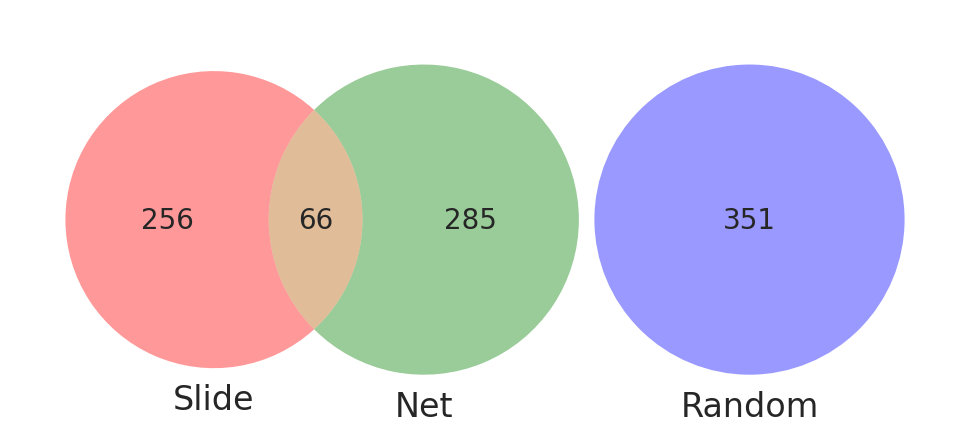

In [25]:
from matplotlib_venn import venn3
slide_pair = set(enrichment_df['TF'].values)
rnd_pair = set(rnd_pairs)
net_pair = set(net_pairs_df['TF'].values)
common_pairs = slide_pair.intersection(net_pair)
venn = venn3([slide_pair, net_pair, rnd_pair], ('Slide', 'Net', 'Random'))
plt.show()

In [34]:
from tqdm import tqdm
net_pair = net_pair - common_pairs  # Exclude pairs that are already in slide_pair
slide_pair = slide_pair - common_pairs  # Exclude pairs that are already in net_pair
score_dict_slide = {}
for pair in tqdm(slide_pair):
    ms_tf1 = abs(integrated[(integrated['gene_short_name'] == pair[0])]['coaccess']).mean()
    ms_tf2 = abs(integrated[(integrated['gene_short_name'] == pair[1])]['coaccess']).mean()
    score = gmean([ms_tf1, ms_tf2]) if not np.isnan(ms_tf1) and not np.isnan(ms_tf2) else 0
    score_dict_slide[pair] = score

score_dict_net = {}
for pair in tqdm(net_pair):
    ms_tf1 = abs(integrated[(integrated['gene_short_name'] == pair[0])]['coaccess']).mean()
    ms_tf2 = abs(integrated[(integrated['gene_short_name'] == pair[1])]['coaccess']).mean()
    score = gmean([ms_tf1, ms_tf2]) if not np.isnan(ms_tf1) and not np.isnan(ms_tf2) else 0
    score_dict_net[pair] = score

# score_dict_rnd = {}
# for pair in tqdm(rnd_pair):
#     ms_tf1 = abs(integrated[(integrated['gene_short_name'] == pair[0])]['coaccess']).mean()
#     ms_tf2 = abs(integrated[(integrated['gene_short_name'] == pair[1])]['coaccess']).mean()
#     score = gmean([ms_tf1, ms_tf2]) if not np.isnan(ms_tf1) and not np.isnan(ms_tf2) else 0
#     score_dict_rnd[pair] = score

100%|██████████| 285/285 [00:18<00:00, 15.39it/s]


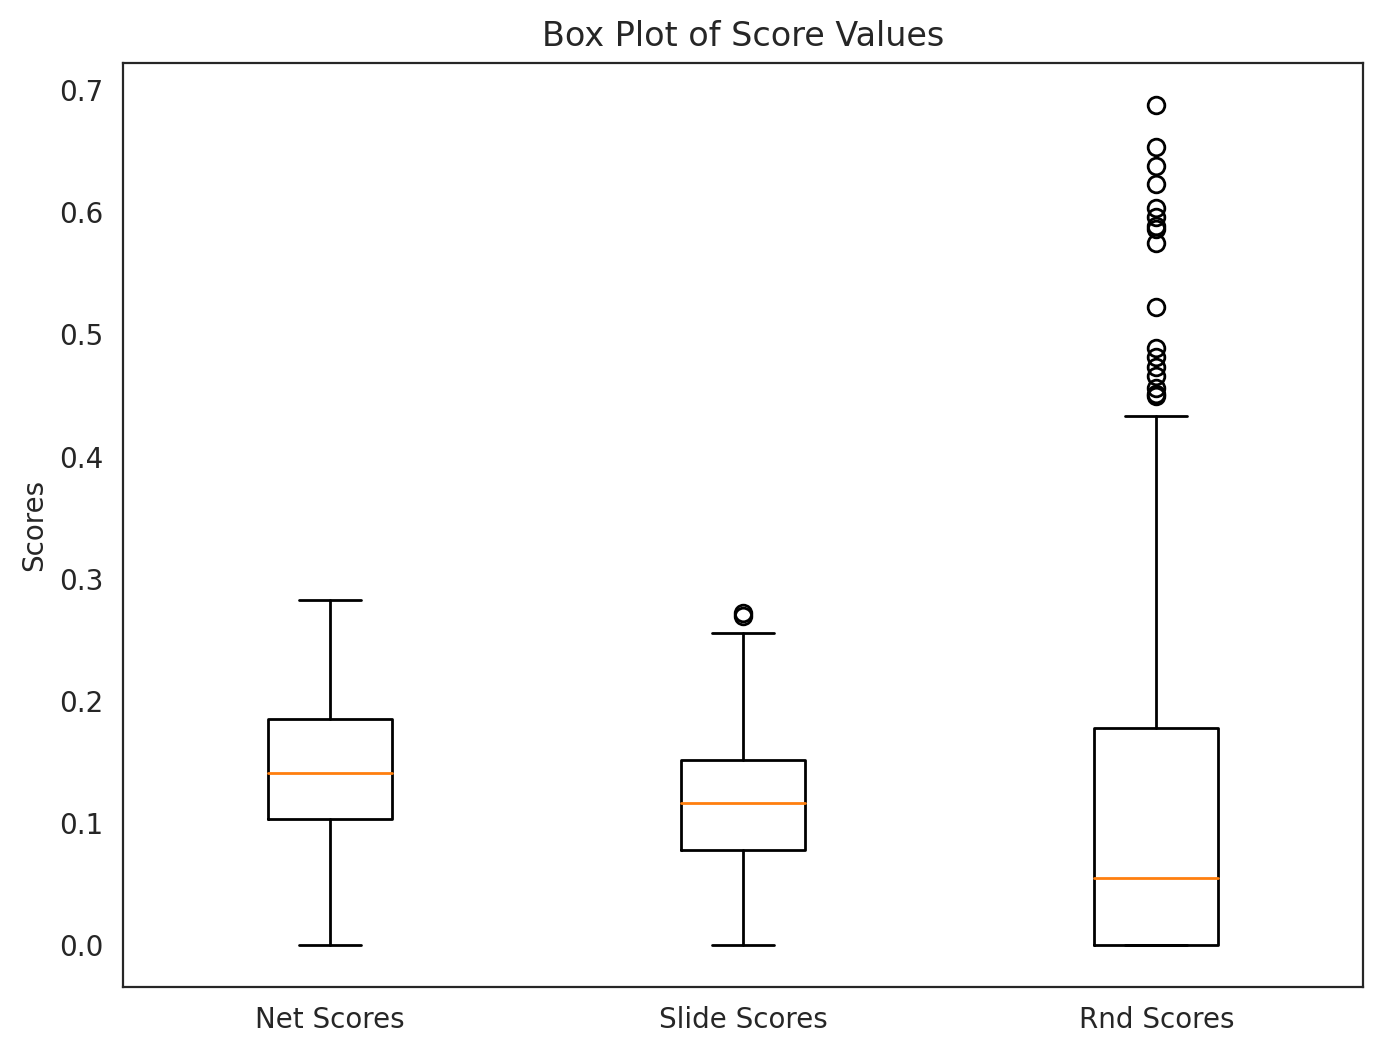

In [35]:
# Extract values from score_dict_net and score_dict_slide
net_scores = [v for v in score_dict_net.values() if not np.isnan(v)]
slide_scores = [v for v in score_dict_slide.values() if not np.isnan(v)]
rnd_scores = [v for v in score_dict_rnd.values() if not np.isnan(v)]
# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot([net_scores, slide_scores,rnd_scores ], labels=['Net Scores', 'Slide Scores', 'Rnd Scores'])
plt.title('Box Plot of Score Values')
plt.ylabel('Scores')
plt.show()